## Model Training

Examples of trained RandomForest regressor models on the dataset. More information about the RandomForestRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


For that purpose, two different train-test splits were used:

- A random train-test split, for which the model has also been evaluated using LeaveOneOut cross-validation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html



- A substitution-series-based, with each substitution series being considered a test set, all the remaining series belonging to the train set. An anomaly score using IsolationForest was also calculated based on this split: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from utils import plot_series
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matminer
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
import warnings
warnings.filterwarnings('ignore')

In [2]:
# code for featurizing the original dataset and saving it as dataset_features.csv, requires matminer package
raw_data = pd.read_csv("dataset.csv")
raw_data = raw_data[raw_data['Tc'].notna()]
df = raw_data[["compound","a","Tc","elements"]]
df = StrToComposition().featurize_dataframe(df, "compound")
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df = ep_feat.featurize_dataframe(df, col_id="composition",ignore_errors=True)
df.to_csv('dataset_features.csv', index=False)
df.head()

StrToComposition:   0%|          | 0/147 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/147 [00:00<?, ?it/s]

,compound,a,Tc,elements,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,MoC,4.39,14.30,BASE,"(Mo, C)",6.0,42.0,36.0,24.0,18.0,...,0.0,0.0,0.0,0.0,194.0,229.0,35.0,211.5,17.5,194.0
1,TaC,4.51,10.00,BASE,"(Ta, C)",6.0,73.0,67.0,39.5,33.5,...,0.0,0.0,0.0,0.0,194.0,229.0,35.0,211.5,17.5,194.0
2,NbC,4.50,11.20,BASE,"(Nb, C)",6.0,41.0,35.0,23.5,17.5,...,0.0,0.0,0.0,0.0,194.0,229.0,35.0,211.5,17.5,194.0
3,HfN,4.54,8.83,BASE,"(Hf, N)",7.0,72.0,65.0,39.5,32.5,...,0.0,0.0,0.0,0.0,194.0,194.0,0.0,194.0,0.0,194.0
4,NbN,4.44,15.00,BASE,"(Nb, N)",7.0,41.0,34.0,24.0,17.0,...,0.0,0.0,0.0,0.0,194.0,229.0,35.0,211.5,17.5,194.0


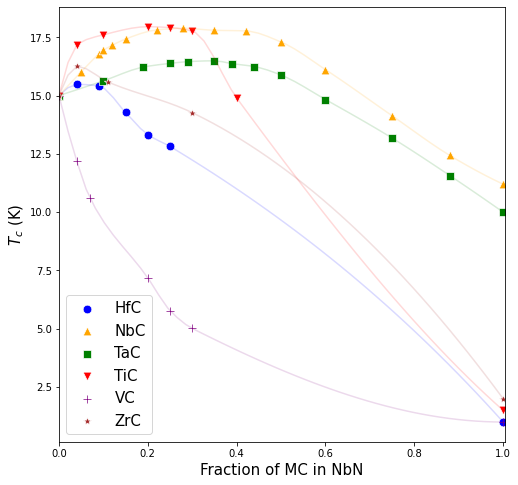

In [3]:
# visualizing a few series
plt.figure(figsize=(8,8))
plot_series(raw_data,'Hf Nb C N', left=15, right=1, label='HfC', color='blue', marker='o')
plot_series(raw_data,'Nb C N', left=15, right=11.2, label='NbC', marker='^', color='orange')
plot_series(raw_data,'Nb Ta C N', left=15, right=10, label='TaC', marker='s', color='green')
plot_series(raw_data,'Nb Ti C N', left=15, right=1.5, label='TiC', marker='v',color='red')
plot_series(raw_data,'V C Nb N', left=15, right=1, label='VC', color='purple', marker='+')
plot_series(raw_data,'Nb Zr C N', left=15, right=2, label='ZrC',marker='*', color='brown')
plt.xlim([0,1.005])
plt.xlabel("Fraction of MC in NbN", fontsize=15)
plt.ylabel("$T_c$ (K)", fontsize=15)
plt.legend(fontsize=15)

In [4]:
# the 12 features selected (see feature selection notebook and paper for details)
feature0 = "MagpieData mean NsValence"
feature1 = "MagpieData mode NsValence"
feature2 = "a"
feature3 = "MagpieData range MendeleevNumber"
feature4 = "MagpieData avg_dev CovalentRadius"
feature5 = "MagpieData range Electronegativity"
feature6 = "MagpieData mean GSvolume_pa"
feature7 = "MagpieData mean CovalentRadius"
feature8 = "MagpieData avg_dev Number"
feature9 = "MagpieData avg_dev Row"
feature10 = "MagpieData mean Number"
feature11 = "MagpieData range CovalentRadius"

test_features =[feature0, feature1, feature2, feature3, feature4, feature5, feature6,
               feature7, feature8, feature9, feature10, feature11]

In [5]:
# training a model based on a random train-test split, and evaluating it using LOO-CV
indices = [0,3,5,7] # indices of the optimal feature combination from exhaustive search that led to best model
sel_features = [test_features[i] for i in indices]
X = df[sel_features]
y = df['Tc']
loo = LeaveOneOut()
loo.get_n_splits(X)
predictions = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    baseline_model = RandomForestRegressor(n_estimators=50, random_state=1, oob_score=False)
    baseline_model.fit(X_train, y_train)
    predictions.append(baseline_model.predict(X_test))
print(f'LOO-CV R2 = {r2_score(y, predictions)}')
print(f'LOO-CV RMSE = {np.sqrt(mean_squared_error(y, predictions))}')
print(f'LOO-CV MAE = {mean_absolute_error(y, predictions)}')

LOO-CV R2 = 0.8531262498636747
LOO-CV RMSE = 1.8218839783086178
LOO-CV MAE = 1.2621054545801362


In [6]:
# training a model based on a substitution-series-based approach
group_1 = ['Hf Mo C', 'Nb Ti C N', 'V C Nb N', 'Nb C V N', 'Hf Nb C', 'Hf Nb C N']
group_3 = ['Nb Ta C', 'Mo Nb C',  'Mo Ta C', 'V C N', 'Ta V C N','Ti V C N','Nb C N', 'Nb V N']
group_2 = ['Hf Nb N', 'Nb Ta C N', 'Nb Ti N', 'Nb Zr C N', 'Nb Zr N']
indices = [0,5] # indices of the optimal feature combination from exhaustive search that led to best model
sel_features = [test_features[i] for i in indices]
X = df[sel_features]
y = df['Tc']

for series in df['elements'].unique()[1:]:
    X_train = df[df.elements!=series][X.columns]
    y_train = df[df.elements!=series]['Tc']
    X_test = df[df.elements==series][X.columns]
    y_test = df[df.elements==series]['Tc']
    model = RandomForestRegressor(n_estimators=50, random_state=1, oob_score=False)
    model.fit(X_train, y_train)
    IF = IsolationForest(n_estimators=50, random_state=42)
    IF.fit(X_train)
    if series in group_1:
        g = 1
    elif series in group_3:
        g = 3
    else:
        g = 2
    print(f"Series : {series}\n")
    print(f'Group : {g}')
    print('training R2 = ' + str(round(model.score(X_train, y_train), 3)))
    print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))))
    print('testing R2 = ' + str(round(model.score(X_test, y_test), 3)))
    print('testing RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))))
    print(f'Isolation Forest score : {np.round(np.mean(IF.decision_function(X_test)),3)}')
    print('\n')

Series : Hf Mo C

Group : 1
training R2 = 0.934
training RMSE = 1.224
testing R2 = 0.505
testing RMSE = 1.421
Isolation Forest score : -0.053


Series : Hf Nb C

Group : 1
training R2 = 0.934
training RMSE = 1.220
testing R2 = -0.46
testing RMSE = 1.089
Isolation Forest score : -0.071


Series : Mo Ta C

Group : 3
training R2 = 0.936
training RMSE = 1.215
testing R2 = -6.371
testing RMSE = 1.513
Isolation Forest score : -0.099


Series : Nb Ta C

Group : 3
training R2 = 0.935
training RMSE = 1.233
testing R2 = -20.834
testing RMSE = 2.731
Isolation Forest score : -0.105


Series : Mo Nb C

Group : 3
training R2 = 0.936
training RMSE = 1.221
testing R2 = -26.57
testing RMSE = 2.677
Isolation Forest score : -0.159


Series : Hf Nb N

Group : 2
training R2 = 0.93
training RMSE = 1.281
testing R2 = -0.033
testing RMSE = 3.258
Isolation Forest score : -0.093


Series : Nb Zr N

Group : 2
training R2 = 0.934
training RMSE = 1.255
testing R2 = -1.344
testing RMSE = 2.323
Isolation Forest scor